In [1]:
import numpy as np
import skfuzzy as fuzz
from matplotlib import pyplot as plt

In [4]:
 # problem - from distance to car in front, determine whether to increase or decrease speed
 x_distance = np.arange(0, 100, 1)
 x_speed = np.arange(-100, 100, 1)

In [66]:
# membership functions
distance_close = fuzz.zmf(x_distance, 10, 50)
distance_good = fuzz.gaussmf(x_distance, 50, 10)
distance_far = fuzz.smf(x_distance, 50, 90)


speed_decel = fuzz.zmf(x_speed, -90, 0)
speed_maintain = fuzz.gaussmf(x_speed, 0, 10)
speed_accel = fuzz.smf(x_speed, 0, 90)

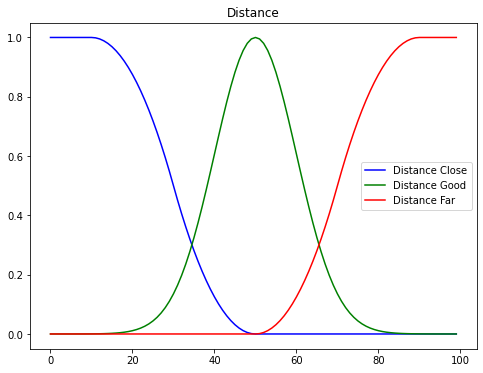

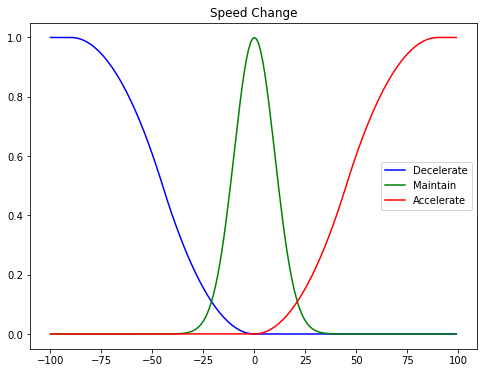

In [70]:
# Visualise membership functions
plt.figure(figsize=(8,6))

plt.plot(x_distance, distance_close, 'b', linewidth=1.5, label="Distance Close")
plt.plot(x_distance, distance_good, 'g', linewidth=1.5, label="Distance Good")
plt.plot(x_distance, distance_far, 'r', linewidth=1.5, label="Distance Far")

plt.title("Distance")
plt.legend(loc="best")

plt.figure(figsize=(8,6))

plt.plot(x_speed, speed_decel, 'b', linewidth=1.5, label="Decelerate")
plt.plot(x_speed, speed_maintain, 'g', linewidth=1.5, label="Maintain")
plt.plot(x_speed, speed_accel, 'r', linewidth=1.5, label="Accelerate")

plt.title("Speed Change")
plt.legend(loc="best")

In [77]:
# Interpret a distance membership

# Read input from user
dist = int(input("Distance from vehicle in front:"))

low_degree = fuzz.interp_membership(x_distance, distance_close, dist)
mid_degree = fuzz.interp_membership(x_distance, distance_good, dist)
hi_degree = fuzz.interp_membership(x_distance, distance_far, dist)

print("Distance:", dist)
print("Close membership:", low_degree)
print("Good membership:", mid_degree)
print("Far membership:", hi_degree)


Distance: 40
Close membership: 0.125
Good membership: 0.6065306597126334
Far membership: 0.0


In [79]:
# Mamdani inference method - min because of AND connective
activation_decel = np.fmin(low_degree, speed_decel)
activation_maintain = np.fmin(mid_degree, speed_maintain)
activation_accel = np.fmin(hi_degree, speed_accel)

'\nprint("Activation decel:", activation_decel)\nprint("Activation maintain:", activation_maintain)\nprint("Activation accel:", activation_accel)\n'

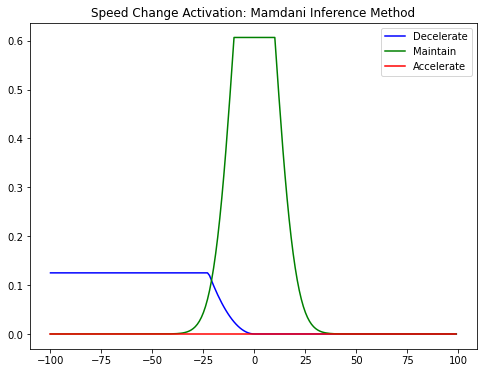

In [81]:
plt.figure(figsize=(8,6))

plt.plot(x_speed, activation_decel, 'b', linewidth=1.5, label="Decelerate")
plt.plot(x_speed, activation_maintain, 'g', linewidth=1.5, label="Maintain")
plt.plot(x_speed, activation_accel, 'r', linewidth=1.5, label="Accelerate")

plt.title("Speed Change Activation: Mamdani Inference Method")
plt.legend(loc="best")
'''
print("Activation decel:", activation_decel)
print("Activation maintain:", activation_maintain)
print("Activation accel:", activation_accel)
'''

In [82]:
# Apply rules - max for aggregation, like or the cases
aggregated = np.fmax(activation_decel, np.fmax(activation_maintain, activation_accel))

In [84]:
# Defuzzification
speed_change_centroid = fuzz.defuzz(x_speed, aggregated, 'centroid')

Defuzzified value: -19.86260788218383


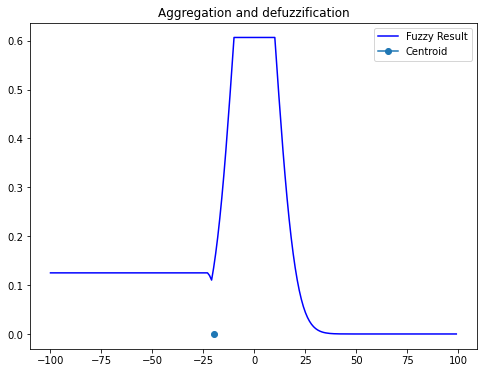

In [87]:
plt.figure(figsize=(8,6))

plt.plot(x_speed, aggregated, 'b', linewidth=1.5, label="Fuzzy Result")
plt.plot(speed_change_centroid, 0.0, linewidth=1.5, label="Centroid", marker="o")

plt.title("Aggregation and defuzzification")
plt.legend(loc="best")
print("Defuzzified value:",speed_change_centroid)